In [ ]:

import pandas as pd
import numpy as np

# text preprocessing
from nltk.tokenize import word_tokenize
import re

import nltk
nltk.download('punkt')
# plots and metrics
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# preparing input to our model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
# from keras.utils import to_categorical

# keras layers
from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, LSTM, GRU, Dense

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
class_names = ['joy', 'fear', 'anger', 'sadness', 'neutral']

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data_train = pd.read_csv('https://raw.githubusercontent.com/amarnathresearch/sentiment_analysis/master/data_train.csv', encoding='utf-8')
data_test = pd.read_csv('https://raw.githubusercontent.com/amarnathresearch/sentiment_analysis/master/data_test.csv', encoding='utf-8')

X_train = data_train.Text
X_test = data_test.Text

y_train = data_train.Emotion
y_test = data_test.Emotion

data = data_train.append(data_test, ignore_index=True)

In [ ]:
data

,Emotion,Text
0,neutral,There are tons of other paintings that I thin...
1,sadness,"Yet the dog had grown old and less capable , a..."
2,fear,When I get into the tube or the train without ...
3,fear,This last may be a source of considerable disq...
4,anger,She disliked the intimacy he showed towards so...
...,...,...
11322,sadness,"My sweetheart left me, or rather we decided to..."
11323,sadness,"Well , it's too bad that we like different kin..."
11324,neutral,It sure is .
11325,sadness,He ’ s got laid off again . I do feel sorry fo...


In [ ]:
print(data.Emotion.value_counts())


joy        2326
sadness    2317
anger      2259
neutral    2254
fear       2171
Name: Emotion, dtype: int64


In [ ]:
bins=[0,50,75, np.inf]
num_words = data.Text.apply(lambda x : len(x.split()))

data['bins']=pd.cut(num_words, bins=[0,50,100,500,800, np.inf], labels=['0-50', '50-100', '300-500','500-800' ,'>800'])

word_distribution = data.groupby('bins').size().reset_index().rename(columns={0:'counts'})

print(word_distribution)

      bins  counts
0     0-50   11086
1   50-100     232
2  300-500       9
3  500-800       0
4     >800       0


In [ ]:
def clean_text(data):
    data = re.sub(r"(#[\d\w\.]+)", '', data)
    data = re.sub(r"(@[\d\w\.]+)", '', data)
    data = word_tokenize(data)
    return data

In [ ]:
texts = [' '.join(clean_text(text)) for text in data.Text]

texts_train = [' '.join(clean_text(text)) for text in X_train]
texts_test = [' '.join(clean_text(text)) for text in X_test]

In [ ]:
print(len(texts), len(texts_train), len(texts_test))


11327 7934 3393


In [ ]:
print(texts_train[0])


There are tons of other paintings that I think are better .


In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)

sequence_train = tokenizer.texts_to_sequences(texts_train)
sequence_test = tokenizer.texts_to_sequences(texts_test)

index_of_words = tokenizer.word_index

# vacab size is number of unique words + reserved 0 index for padding
vocab_size = len(index_of_words) + 1

print('Number of unique words: {}'.format(len(index_of_words)))

Number of unique words: 12088


In [ ]:
print(vocab_size)

12089


In [ ]:
MAX_LENGTH = 50
print(sequence_train[0])
print(sequence_train[1])

[57, 51, 5933, 8, 132, 3296, 11, 1, 119, 51, 345]
[419, 2, 311, 14, 1463, 168, 5, 846, 2365, 5, 45, 75, 2, 5934, 14, 138, 5, 2087, 18, 180, 847, 11, 2, 311, 14, 816, 3, 1708, 5, 284, 37, 277, 154]


In [ ]:
X_train_pad = pad_sequences(sequence_train, maxlen = MAX_LENGTH )
X_test_pad = pad_sequences(sequence_test, maxlen = MAX_LENGTH )

In [ ]:
print(X_train_pad[0])
print(X_train_pad[1])


[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0   57   51 5933
    8  132 3296   11    1  119   51  345]
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0  419    2  311   14 1463  168    5  846 2365    5   45
   75    2 5934   14  138    5 2087   18  180  847   11    2  311   14
  816    3 1708    5  284   37  277  154]


In [ ]:
encoding = {
    'joy': 0,
    'fear': 1,
    'anger': 2,
    'sadness': 3,
    'neutral': 4
}

# Integer labels
y_train = [encoding[x] for x in data_train.Emotion]
y_test = [encoding[x] for x in data_test.Emotion]

In [ ]:
print(texts_train[0])
print(sequence_train[0])
print(y_train[0])

There are tons of other paintings that I think are better .
[57, 51, 5933, 8, 132, 3296, 11, 1, 119, 51, 345]
4


In [ ]:
from tensorflow.keras.utils import to_categorical


In [ ]:

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

y_train[0]

array([0., 0., 0., 0., 1.], dtype=float32)

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout, Embedding, LSTM, Flatten,SimpleRNN
from keras.layers import Conv1D, MaxPooling1D
from keras import backend as K
from keras.models import Model
from keras.callbacks import ModelCheckpoint

In [ ]:
num_class = len(class_names)
# num_class = 5

In [ ]:
inputs = Input(shape=(MAX_LENGTH, ))
print(inputs)

KerasTensor(type_spec=TensorSpec(shape=(None, 50), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")


In [ ]:

embedding_layer = Embedding(100, 124, input_length=MAX_LENGTH)(inputs)

In [ ]:
print(embedding_layer)

KerasTensor(type_spec=TensorSpec(shape=(None, 50, 124), dtype=tf.float32, name=None), name='embedding/embedding_lookup/Identity_1:0', description="created by layer 'embedding'")


In [ ]:

x = Flatten()(embedding_layer)
x = Dense(124, activation='relu')(x)
x = Dense(124, activation='relu')(x)
x = Dense(124, activation='relu')(x)
x = Dense(32, activation='relu')(x)

predictions = Dense(num_class, activation='softmax')(x)


model = Model(inputs=[inputs], outputs=predictions)
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['acc'])

model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50)]              0         
                                                                 
 embedding (Embedding)       (None, 50, 124)           12400     
                                                                 
 flatten (Flatten)           (None, 6200)              0         
                                                                 
 dense (Dense)               (None, 124)               768924    
                                                                 
 dense_1 (Dense)             (None, 124)               15500     
                                                                 
 dense_2 (Dense)             (None, 124)               15500     
                                                                 
 dense_3 (Dense)             (None, 32)                4000  

In [ ]:
filepath="weights-simple.hdf5"
checkpointer = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

# history = model.fit([X_train_pad], batch_size=64, y=to_categorical(y_train), verbose=1, validation_split=0.25, 
#           shuffle=True, epochs=5, callbacks=[checkpointer])
batch_size = 128
epochs = 50

hist = model.fit(X_train_pad, y_train, batch_size=batch_size, epochs=epochs,
                 validation_data=(X_test_pad,y_test), callbacks=[checkpointer])

Epoch 1/50


InvalidArgumentError: ignored

In [ ]:
gru_output_size = 128
bidirectional = True
embed_num_dims = 300
embedding_layer = Embedding(vocab_size,
                         embed_num_dims,
                         input_length = MAX_LENGTH,
                         
                         trainable=False)
# Embedding Layer, LSTM or biLSTM, Dense, softmax
# embedding_layer = Embedding(vocab_size,
#                             128,
#                             input_length=MAX_LENGTH)(inputs)

model = Sequential()
model.add(embedding_layer)


model.add(SimpleRNN(
    4, return_sequences=True, return_state=True))

ValueError: ignored

In [ ]:
inputs = np.random.random([32, 10, 18]).astype(np.float32)
simple_rnn = SimpleRNN(4)

output = simple_rnn(inputs)  # The output has shape `[32, 4]`.

simple_rnn = SimpleRNN(
    4, return_sequences=True, return_state=True)

# whole_sequence_output has shape `[32, 10, 4]`.
# final_state has shape `[32, 4]`.
whole_sequence_output, final_state = simple_rnn(inputs)
print(whole_sequence_output, final_state)

tf.Tensor(
[[[ 7.02766776e-02  3.96084607e-01 -2.54630625e-01  5.27687728e-01]
  [ 7.61674643e-01  9.62012708e-01 -2.05519140e-01  8.39313269e-01]
  [ 9.05095875e-01  9.45671618e-01  4.99280915e-02  5.57762265e-01]
  ...
  [ 8.66294920e-01  8.90930474e-01 -4.37667847e-01 -7.33063072e-02]
  [ 4.60233927e-01  7.13169336e-01  4.83835116e-02 -8.07647526e-01]
  [ 4.41982061e-01  3.28928977e-01 -5.42510271e-01  1.12216763e-01]]

 [[ 1.58411060e-02  8.43402863e-01 -6.25461221e-01  5.03184855e-01]
  [-1.24309309e-01  9.02249634e-01 -3.38015229e-01  1.30349517e-01]
  [ 5.29146612e-01  6.31313741e-01  8.13764036e-01  3.43258590e-01]
  ...
  [ 8.03155184e-01  5.75568303e-02  3.25490832e-02  6.02909066e-02]
  [ 8.79943490e-01  3.75468731e-01 -2.43136901e-02  8.97714030e-03]
  [ 7.97580361e-01  2.88858205e-01 -6.10705949e-02 -2.21826091e-01]]

 [[ 1.83821544e-01  7.72881329e-01 -2.89545655e-01  6.36136830e-01]
  [ 8.45261574e-01  9.82542336e-01  1.01277314e-01  8.22861075e-01]
  [ 8.22428167e-01  9

In [ ]:
gru_output_size = 128
bidirectional = True
embed_num_dims = 300
embedding_layer = Embedding(vocab_size,
                         embed_num_dims,
                         input_length = MAX_LENGTH,
                         
                         trainable=False)
# Embedding Layer, LSTM or biLSTM, Dense, softmax
# embedding_layer = Embedding(vocab_size,
#                             128,
#                             input_length=MAX_LENGTH)(inputs)

model = Sequential()
model.add(embedding_layer)

if bidirectional:
    model.add(Bidirectional(GRU(units=gru_output_size,
                              dropout=0.2,
                              recurrent_dropout=0.2)))
else:
     model.add(GRU(units=gru_output_size,
                dropout=0.2, 
                recurrent_dropout=0.2))

model.add(Dense(num_class, activation='softmax'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['acc'])

model.summary()
# filepath="weights-simple.hdf5"
checkpoint_path = "amar_cp.ckpt"

# Create a callback that saves the model's weights
checkpointer = ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
# checkpointer = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

# history = model.fit([X_train_pad], batch_size=64, y=to_categorical(y_train), verbose=1, validation_split=0.25, 
#           shuffle=True, epochs=5, callbacks=[checkpointer])
batch_size = 128
epochs = 50

hist = model.fit(X_train_pad, y_train, batch_size=batch_size, epochs=epochs,
                 validation_data=(X_test_pad,y_test), callbacks=[checkpointer])


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 50, 300)           3626700   
                                                                 
 bidirectional (Bidirectiona  (None, 256)              330240    
 l)                                                              
                                                                 
 dense_5 (Dense)             (None, 5)                 1285      
                                                                 
Total params: 3,958,225
Trainable params: 331,525
Non-trainable params: 3,626,700
_________________________________________________________________
Epoch 1/50


KeyboardInterrupt: ignored

In [ ]:
inputs = Input(shape=(MAX_LENGTH, ))
embedding_layer = Embedding(vocab_size,
                            128,
                            input_length=MAX_LENGTH)(inputs)


x = LSTM(128)(embedding_layer)
x = Dense(64, activation='relu')(x)

x = Dense(32, activation='relu')(x)
predictions = Dense(num_class, activation='softmax')(x)
model = Model(inputs=[inputs], outputs=predictions)
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['acc'])

model.summary()

# filepath="weights-simple.hdf5"
checkpoint_path = "/content/drive/MyDrive/dataset/sentiment/weights/amar_lstm.ckpt"

# Create a callback that saves the model's weights
checkpointer = ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
# checkpointer = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

# history = model.fit([X_train_pad], batch_size=64, y=to_categorical(y_train), verbose=1, validation_split=0.25, 
#           shuffle=True, epochs=5, callbacks=[checkpointer])
batch_size = 128
epochs = 20

hist = model.fit(X_train_pad, y_train, batch_size=batch_size, epochs=epochs,
                 validation_data=(X_test_pad,y_test), callbacks=[checkpointer])

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 50)]              0         
                                                                 
 embedding_4 (Embedding)     (None, 50, 128)           1547392   
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 dense_8 (Dense)             (None, 64)                8256      
                                                                 
 dense_9 (Dense)             (None, 32)                2080      
                                                                 
 dense_10 (Dense)            (None, 5)                 165       
                                                                 
Total params: 1,689,477
Trainable params: 1,689,477
Non-tra

KeyboardInterrupt: ignored

In [ ]:
model.save('/content/drive/MyDrive/dataset/sentiment/weights/amarnath_lstm.h5') #sAVING THE MODEL
# model.save_weights("amar_cp_final.ckpt")

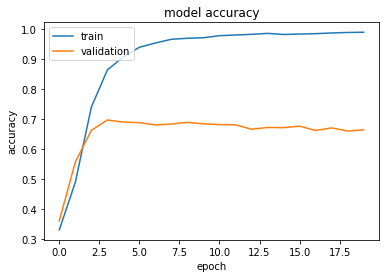

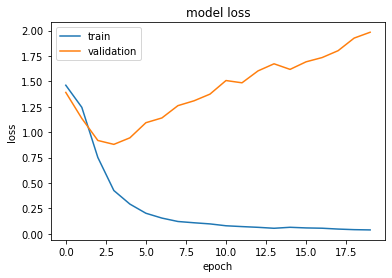

In [ ]:
#  "Accuracy"
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# "Loss"
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
# num_classes = 5
# model = Sequential()
# model.add(Conv1D(filters=64, kernel_size=3,
#                  activation='relu',
#                  input_shape=(500,300)))
# model.add(Conv1D(128, kernel_size=5, activation='relu'))
# model.add(MaxPooling1D(pool_size=1))
# model.add(Conv1D(128, kernel_size=5, activation='relu'))
# model.add(MaxPooling1D(pool_size=1))
# model.add(Conv1D(128, kernel_size=5, activation='relu'))
# model.add(MaxPooling1D(pool_size=1))
# model.add(Conv1D(128, kernel_size=5, activation='relu'))
# model.add(MaxPooling1D(pool_size=1))
# model.add(Flatten())
# model.add(Dense(64, activation='relu'))

# model.add(Dense(num_classes, activation='softmax')

In [ ]:
predictions = model.predict(X_test_pad)
predictions = np.argmax(predictions, axis=1)
predictions = [class_names[pred] for pred in predictions]

In [ ]:
print("Accuracy: {:.2f}%".format(accuracy_score(data_test.Emotion, predictions) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(data_test.Emotion, predictions, average='micro') * 100))

Accuracy: 66.46%

F1 Score: 66.46


In [ ]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    '''
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    '''
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    
    # Set size
    fig.set_size_inches(12.5, 7.5)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.grid(False)
    
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


F1 Score: 66.46


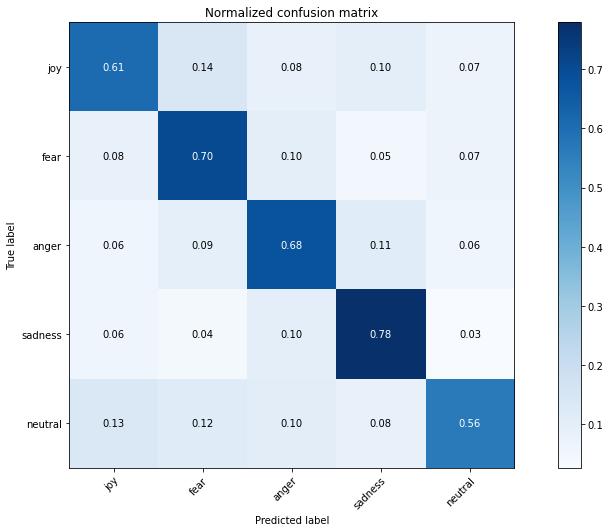

In [ ]:
print("\nF1 Score: {:.2f}".format(f1_score(data_test.Emotion, predictions, average='micro') * 100))

# Plot normalized confusion matrix
plot_confusion_matrix(data_test.Emotion, predictions, classes=class_names, normalize=True, title='Normalized confusion matrix')
plt.show()

In [ ]:
print('Message: {}\nPredicted: {}'.format(X_test[4], predictions[4]))


Message: My boyfriend didn't turn up after promising that he was coming.
Predicted: neutral


In [ ]:
import time

message = ['delivery was hour late and my pizza was cold!']

seq = tokenizer.texts_to_sequences(message)
padded = pad_sequences(seq, maxlen=MAX_LENGTH)

start_time = time.time()
pred = model.predict(padded)

print('Message: ' + str(message))
print('predicted: {} ({:.2f} seconds)'.format(class_names[np.argmax(pred)], (time.time() - start_time)))

Message: ['delivery was hour late and my pizza was cold!']
predicted: fear (0.05 seconds)


In [ ]:
# from keras.models import 
from tensorflow.keras.models import load_model
# model.load_weights('amar_cp_final.ckpt', compile=False)
predictor = load_model('/content/drive/MyDrive/dataset/sentiment/weights/amarnath_lstm.h5')


message_list = [['delivery was hour late and my pizza was cold!'],
                ['They seemed anxious and hesitant about leaving , as if uncertain of which direction to take .'],
                ['Leading scorer Paul Wilkinson struck his 20th goal of the season against his former club but looked glum as he left the dressing room . ']]

for message in message_list:
    seq = tokenizer.texts_to_sequences(message)
    padded = pad_sequences(seq, maxlen=MAX_LENGTH)

    start_time = time.time()
    pred = predictor.predict(padded)

    print('Message: ' + str(message[0]))
    print('predicted: {} ({:.2f} seconds)'.format(class_names[np.argmax(pred)], (time.time() - start_time)))

Message: delivery was hour late and my pizza was cold!
predicted: fear (0.56 seconds)
Message: They seemed anxious and hesitant about leaving , as if uncertain of which direction to take .
predicted: fear (0.04 seconds)
Message: Leading scorer Paul Wilkinson struck his 20th goal of the season against his former club but looked glum as he left the dressing room . 
predicted: sadness (0.04 seconds)


In [ ]:
from tensorflow.keras.models import load_model
# model.load_weights('amar_cp_final.ckpt', compile=False)
# predictor = load_model('/content/amarnath_lstm.h5')


message_list = [['I am happy today']]

for message in message_list:
    seq = tokenizer.texts_to_sequences(message)
    padded = pad_sequences(seq, maxlen=MAX_LENGTH)

    start_time = time.time()
    pred = model.predict(padded)

    print('Message: ' + str(message[0]))
    print('predicted: {} ({:.2f} seconds)'.format(class_names[np.argmax(pred)], (time.time() - start_time)))

Message: I am happy today
predicted: joy (0.04 seconds)


In [ ]:
# Machine Learning / Deep Learning / Computer Vision 
# Make a system intelligence - 


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing

import numpy as np
import os
import time

In [ ]:
path_to_file = tf.keras.utils.get_file('shakespeare.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')


In [ ]:
# Read, then decode for py2 compat.
text = open(path_to_file, 'rb').read().decode(encoding='utf-8')
# length of text is the number of characters in it
print(f'Length of text: {len(text)} characters')

Length of text: 1115394 characters


In [ ]:
print(text[:252])


First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

A


In [ ]:
# The unique characters in the file
vocab = sorted(set(text))
print(f'{len(vocab)} unique characters')



65 unique characters


In [ ]:
ids_from_chars = preprocessing.StringLookup(
    vocabulary=list(vocab), mask_token=None)

In [ ]:
example_texts = ['abcdefg', 'xyz']

chars = tf.strings.unicode_split(example_texts, input_encoding='UTF-8')
chars

<tf.RaggedTensor [[b'a', b'b', b'c', b'd', b'e', b'f', b'g'], [b'x', b'y', b'z']]>

In [ ]:
ids = ids_from_chars(chars)
ids

<tf.RaggedTensor [[40, 41, 42, 43, 44, 45, 46], [63, 64, 65]]>

In [ ]:
chars_from_ids = tf.keras.layers.experimental.preprocessing.StringLookup(
    vocabulary=ids_from_chars.get_vocabulary(), invert=True, mask_token=None)

In [ ]:
chars = chars_from_ids(ids)
chars

<tf.RaggedTensor [[b'a', b'b', b'c', b'd', b'e', b'f', b'g'], [b'x', b'y', b'z']]>

In [ ]:
tf.strings.reduce_join(chars, axis=-1).numpy()

array([b'abcdefg', b'xyz'], dtype=object)

In [ ]:
def text_from_ids(ids):
  return tf.strings.reduce_join(chars_from_ids(ids), axis=-1)

In [ ]:
all_ids = ids_from_chars(tf.strings.unicode_split(text, 'UTF-8'))
all_ids

<tf.Tensor: shape=(1115394,), dtype=int64, numpy=array([19, 48, 57, ..., 46,  9,  1])>

In [ ]:
ids_dataset = tf.data.Dataset.from_tensor_slices(all_ids)

In [ ]:
for ids in ids_dataset.take(10):
    print(chars_from_ids(ids).numpy().decode('utf-8'))

F
i
r
s
t
 
C
i
t
i


In [ ]:
seq_length = 100
examples_per_epoch = len(text)//(seq_length+1)

In [ ]:
sequences = ids_dataset.batch(seq_length+1, drop_remainder=True)

for seq in sequences.take(1):
  print(chars_from_ids(seq))

tf.Tensor(
[b'F' b'i' b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':'
 b'\n' b'B' b'e' b'f' b'o' b'r' b'e' b' ' b'w' b'e' b' ' b'p' b'r' b'o'
 b'c' b'e' b'e' b'd' b' ' b'a' b'n' b'y' b' ' b'f' b'u' b'r' b't' b'h'
 b'e' b'r' b',' b' ' b'h' b'e' b'a' b'r' b' ' b'm' b'e' b' ' b's' b'p'
 b'e' b'a' b'k' b'.' b'\n' b'\n' b'A' b'l' b'l' b':' b'\n' b'S' b'p' b'e'
 b'a' b'k' b',' b' ' b's' b'p' b'e' b'a' b'k' b'.' b'\n' b'\n' b'F' b'i'
 b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':' b'\n' b'Y'
 b'o' b'u' b' '], shape=(101,), dtype=string)


In [ ]:
for seq in sequences.take(5):
  print(text_from_ids(seq).numpy())

b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '
b'are all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you k'
b"now Caius Marcius is chief enemy to the people.\n\nAll:\nWe know't, we know't.\n\nFirst Citizen:\nLet us ki"
b"ll him, and we'll have corn at our own price.\nIs't a verdict?\n\nAll:\nNo more talking on't; let it be d"
b'one: away, away!\n\nSecond Citizen:\nOne word, good citizens.\n\nFirst Citizen:\nWe are accounted poor citi'


In [ ]:
def split_input_target(sequence):
    input_text = sequence[:-1]
    target_text = sequence[1:]
    return input_text, target_text

In [ ]:
split_input_target(list("Tensorflow"))

(['T', 'e', 'n', 's', 'o', 'r', 'f', 'l', 'o'],
 ['e', 'n', 's', 'o', 'r', 'f', 'l', 'o', 'w'])

In [ ]:
dataset = sequences.map(split_input_target)

In [ ]:
for input_example, target_example in dataset.take(1):
    print("Input :", text_from_ids(input_example).numpy())
    print("Target:", text_from_ids(target_example).numpy())

Input : b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'
Target: b'irst Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '


In [ ]:
# Batch size
BATCH_SIZE = 64

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 10000

dataset = (
    dataset
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE))

dataset

<PrefetchDataset shapes: ((64, 100), (64, 100)), types: (tf.int64, tf.int64)>

In [ ]:
# Length of the vocabulary in chars
vocab_size = len(vocab)

# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 1024

In [ ]:
class MyModel(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, rnn_units):
    super().__init__(self)
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(rnn_units,
                                   return_sequences=True,
                                   return_state=True)
    self.dense = tf.keras.layers.Dense(vocab_size)

  def call(self, inputs, states=None, return_state=False, training=False):
    x = inputs
    x = self.embedding(x, training=training)
    if states is None:
      states = self.gru.get_initial_state(x)
    x, states = self.gru(x, initial_state=states, training=training)
    x = self.dense(x, training=training)

    if return_state:
      return x, states
    else:
      return x

In [ ]:
model = MyModel(
    # Be sure the vocabulary size matches the `StringLookup` layers.
    vocab_size=len(ids_from_chars.get_vocabulary()),
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)

In [ ]:
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(64, 100, 66) # (batch_size, sequence_length, vocab_size)


In [ ]:
model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     multiple                  16896     
                                                                 
 gru_1 (GRU)                 multiple                  3938304   
                                                                 
 dense_11 (Dense)            multiple                  67650     
                                                                 
Total params: 4,022,850
Trainable params: 4,022,850
Non-trainable params: 0
_________________________________________________________________


In [ ]:
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices, axis=-1).numpy()

In [ ]:
sampled_indices

array([ 3, 44, 24, 18, 29, 26, 65,  3, 54, 61, 34, 64, 14, 51, 37, 54, 12,
       16, 33, 36, 28, 38, 40, 49, 56, 35, 17, 30, 21, 34, 39, 15, 48, 48,
        6,  4, 32, 28, 48, 23, 17, 64, 49, 56, 54, 52, 25, 30, 32, 18, 16,
       10, 14, 10, 51, 65, 25, 11, 13,  7, 42, 62, 60, 19, 22, 29, 45, 12,
       52, 40, 28, 40, 61, 28,  9, 37, 31,  7, 32, 53, 62, 41, 34, 50,  4,
       26, 27, 28, 43, 22,  4, 39, 27, 32, 46,  7,  0,  6, 44, 47])

In [ ]:
print("Input:\n", text_from_ids(input_example_batch[0]).numpy())
print()
print("Next Char Predictions:\n", text_from_ids(sampled_indices).numpy())

Input:
 b'ate of service?\n\nBRUTUS:\nI talk of that, that know it.\n\nCORIOLANUS:\nYou?\n\nMENENIUS:\nIs this the prom'

Next Char Predictions:
 b"!eKEPMz!ovUyAlXo;CTWOYajqVDQHUZBii'$SOiJDyjqomLQSEC3A3lzL:?,cwuFIPf;maOavO.XR,SnwbUk$MNOdI$ZNSg,[UNK]'eh"


In [ ]:
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)

In [ ]:
example_batch_loss = loss(target_example_batch, example_batch_predictions)
mean_loss = example_batch_loss.numpy().mean()
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("Mean loss:        ", mean_loss)

Prediction shape:  (64, 100, 66)  # (batch_size, sequence_length, vocab_size)
Mean loss:         4.189854


In [ ]:
model.compile(optimizer='adam', loss=loss)

In [ ]:
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

In [ ]:
EPOCHS = 20

In [ ]:
history = model.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])

Epoch 1/20
172/172 [==============================] - 737s 4s/step - loss: 2.7154
Epoch 2/20
172/172 [==============================] - 736s 4s/step - loss: 1.9898
Epoch 3/20
 74/172 [===========>..................] - ETA: 7:00 - loss: 1.7715